# Learn ranking utility function

## Practical explanation

This notebook combines the code in `Chapter_12_Section_1_RankNet.ipynb` and `Chapter_12_Section_2_Loading_VGG_Model.ipynb` to perform the following:
  * Extract first (start_imgs) and last (end_imgs) frames of a video demonstrating the folding of clothes.
  * Embedd these images using the fully connected output layer of the vgg model shown in `Chapter_12_Section_2_Loading_VGG_Model.ipynb`.
  * Use the nn model in `Chapter_12_Section_1_RankNet.ipynb` to learn a model to learn a utility function that ranks the last frame (folded) higher than the first frame (unfolded).
  * Check that the utility function has learned to score the frames in a video in increasing order as the cloth progress from unfolded to folded.
  
See "Jointly Learning Grounded Task Structures from Language Instruction and
Visual Demonstration" at http://shukla.io/docs/2016_EMNLP.pdf

## Code

Download cloth folding dataset from https://data.mendeley.com/datasets/c7y3hcrj7z/1. 

Extract the zip. Keep note of where you extract it; we'll call that location `DATASET_DIR`.

/home/damianos/.conda/envs/tfCPU/lib/python3.5/site-packages/ipykernel/__main__.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/damianos/.conda/envs/tfCPU/lib/python3.5/site-packages/ipykernel/__main__.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Images of starting state (45, 224, 224, 3)
Images of ending state (45, 224, 224, 3)


Text(0.5, 1.0, 'End')

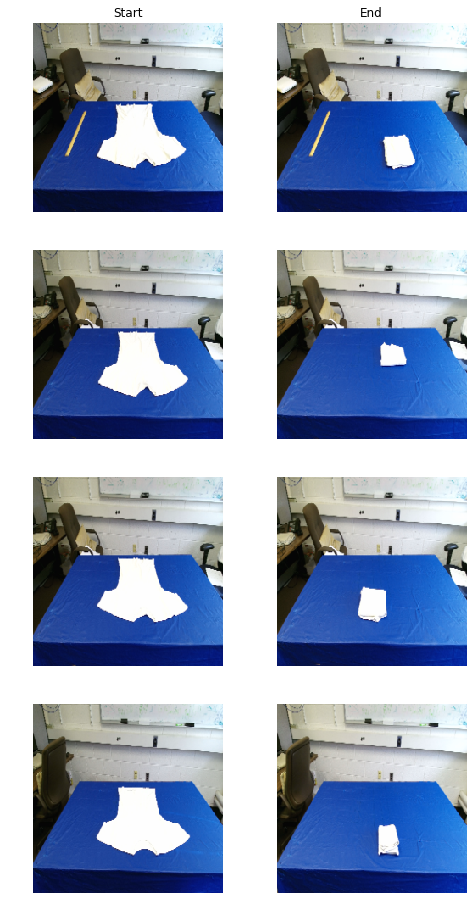

In [1]:
import tensorflow as tf
import numpy as np
from vgg16 import vgg16
import glob, os
from scipy.misc import imread, imresize
%matplotlib inline
from matplotlib import pyplot as plt

DATASET_DIR = './data/cloth_folding_rgb_vids'
NUM_VIDS = 45

def get_img_pair(video_id):
    """Extract tuples of start and end images"""
    img_files = sorted(glob.glob(os.path.join(DATASET_DIR, video_id, '*.png')))
    start_img = img_files[0]
    end_img = img_files[-1]
    pair = []
    for image_file in [start_img, end_img]:
        img_original = imread(image_file)
        img_resized = imresize(img_original, (224, 224))
        pair.append(img_resized)
    return tuple(pair)

start_imgs = []
end_imgs= []
# Extract list of start and end images of unfolded/folded shirts
for vid_id in range(1, NUM_VIDS + 1):
    start_img, end_img = get_img_pair(str(vid_id))
    start_imgs.append(start_img)
    end_imgs.append(end_img)
print('Images of starting state {}'.format(np.shape(start_imgs)))
print('Images of ending state {}'.format(np.shape(end_imgs)))
nExamples=4
fig, ax = plt.subplots(nExamples,2,figsize=(8,16))
for i in range(nExamples):
    ax[i,0].imshow(start_imgs[i])
    ax[i,0].set_axis_off()
    ax[i,1].imshow(end_imgs[i])
    ax[i,1].set_axis_off()
ax[0,0].set_title('Start')
ax[0,1].set_title('End')


In [2]:
imgs_plc = tf.placeholder(tf.float32, [None, 224, 224, 3])

In [3]:
# nn model to learn to rank two image embeddings
# See Concept01_ranknet_DC.ipynb


# this is the size of the embedding
n_features = 4096 
n_hidden = 10 # n_features * 2

with tf.name_scope("input"):
    # The input to the ranking nn is the embedding NOT the image
    x1 = tf.placeholder(tf.float32, [None, n_features], name="x1")
    x2 = tf.placeholder(tf.float32, [None, n_features], name="x2")
    dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_prob')


# Two hidden layers with a relu activation
# Each hidden layer will take an x1 and x2 inputs
with tf.name_scope("hidden_layer"):
    with tf.name_scope("weights"):
        w1 = tf.Variable(tf.random_normal([n_features, n_hidden]), 
                         name="w1")
        tf.summary.histogram("w1", w1)
        b1 = tf.Variable(tf.random_normal([n_hidden]), name="b1")
        tf.summary.histogram("b1", b1)
 
    with tf.name_scope("output"):
        h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x1,w1) + b1), 
                           keep_prob=dropout_keep_prob)
        tf.summary.histogram("h1", h1)
        h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(x2, w1) + b1), 
                           keep_prob=dropout_keep_prob)
        tf.summary.histogram("h2", h2)
 
# Two output layers without an activation function
# corresponding to each input image embedding
with tf.name_scope("output_layer"):
    with tf.name_scope("weights"):
        w2 = tf.Variable(tf.random_normal([n_hidden, 1]), name="w2")
        tf.summary.histogram("w2", w2)
        b2 = tf.Variable(tf.random_normal([1]), name="b2")
        tf.summary.histogram("b2", b2)
 
    with tf.name_scope("output"):
        s1 = tf.matmul(h1, w2) + b2
        s2 = tf.matmul(h2, w2) + b2
 
 
with tf.name_scope("loss"):
    s12 = s1 - s2
    s12_flat = tf.reshape(s12, [-1])    
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.zeros_like(s12_flat),
        logits=s12_flat + 1)
    
    loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar("loss", loss)
 
with tf.name_scope("train_op"):
    train_op = tf.train.AdamOptimizer(0.001).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [4]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [5]:
print('Loading model...')
vgg = vgg16(imgs_plc, './vggWeights/vgg16_weights.npz', sess)
print('Done loading!')

Loading model...
0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)
Done loading!


In [6]:
# get embeddings for images 
start_imgs_embedded = sess.run(vgg.fc1, feed_dict={vgg.imgs: start_imgs})
end_imgs_embedded = sess.run(vgg.fc1, feed_dict={vgg.imgs: end_imgs})

idxs = np.random.choice(NUM_VIDS, NUM_VIDS, replace=False)
train_idxs = idxs[0:int(NUM_VIDS * 0.75)]
test_idxs = idxs[int(NUM_VIDS * 0.75):]

train_start_imgs = start_imgs_embedded[train_idxs]
train_end_imgs = end_imgs_embedded[train_idxs]
test_start_imgs = start_imgs_embedded[test_idxs]
test_end_imgs = end_imgs_embedded[test_idxs]

print('Train start imgs {}'.format(np.shape(train_start_imgs)))
print('Train end imgs {}'.format(np.shape(train_end_imgs)))
print('Test start imgs {}'.format(np.shape(test_start_imgs)))
print('Test end imgs {}'.format(np.shape(test_end_imgs)))

Train start imgs (33, 4096)
Train end imgs (33, 4096)
Test start imgs (12, 4096)
Test end imgs (12, 4096)


In [7]:
# run nn model that learn to rank start and end images
train_y1 = np.expand_dims(np.zeros(np.shape(train_start_imgs)[0]), 
                          axis=1)
train_y2 = np.expand_dims(np.ones(np.shape(train_end_imgs)[0]),
                          axis=1)
for epoch in range(100):
    for i in range(np.shape(train_start_imgs)[0]):
        _, cost_val = sess.run([train_op, loss], 
                               feed_dict={x1: train_start_imgs[i:i+1,:], 
                                          x2: train_end_imgs[i:i+1,:], 
                                          dropout_keep_prob: 0.5})
    print('{}. {}'.format(epoch, cost_val))
    s1_val, s2_val = sess.run([s1, s2], feed_dict={x1: test_start_imgs, 
                                                   x2: test_end_imgs, 
                                                   dropout_keep_prob: 1})
    print('Accuracy: {}%'.format(100 * np.mean(s1_val < s2_val)))


0. 0.0
Accuracy: 75.0%
1. 0.0
Accuracy: 91.66666666666666%
2. 0.0
Accuracy: 91.66666666666666%
3. 0.0
Accuracy: 100.0%
4. 0.0
Accuracy: 100.0%
5. 0.0
Accuracy: 100.0%
6. 0.0
Accuracy: 100.0%
7. 0.0
Accuracy: 100.0%
8. 0.0
Accuracy: 100.0%
9. 0.0
Accuracy: 100.0%
10. 0.0
Accuracy: 100.0%
11. 0.0
Accuracy: 100.0%
12. 0.0
Accuracy: 100.0%
13. 0.0
Accuracy: 100.0%
14. 0.0
Accuracy: 100.0%
15. 0.0
Accuracy: 100.0%
16. 0.0
Accuracy: 100.0%
17. 0.0
Accuracy: 100.0%
18. 0.0
Accuracy: 100.0%
19. 0.0
Accuracy: 100.0%
20. 0.0
Accuracy: 100.0%
21. 0.0
Accuracy: 100.0%
22. 0.0
Accuracy: 100.0%
23. 0.0
Accuracy: 100.0%
24. 0.0
Accuracy: 100.0%
25. 0.0
Accuracy: 100.0%
26. 0.0
Accuracy: 100.0%
27. 0.0
Accuracy: 100.0%
28. 0.0
Accuracy: 100.0%
29. 0.0
Accuracy: 100.0%
30. 0.0
Accuracy: 100.0%
31. 0.0
Accuracy: 100.0%
32. 0.0
Accuracy: 100.0%
33. 0.0
Accuracy: 100.0%
34. 0.0
Accuracy: 100.0%
35. 0.0
Accuracy: 100.0%
36. 0.0
Accuracy: 100.0%
37. 0.0
Accuracy: 100.0%
38. 0.0
Accuracy: 100.0%
39. 0.0
Accu

In [8]:
# See how well our nn model has learned to rank sequential images of a video
# NOT just start and end frames as it was trained on
def get_img_seq(video_id):
    img_files = sorted(glob.glob(os.path.join(DATASET_DIR, 
                                              video_id, '*.png')))
    imgs = []
    for image_file in img_files:
        img_original = imread(image_file)
        img_resized = imresize(img_original, (224, 224))
        imgs.append(img_resized)
    return imgs

imgs = get_img_seq('2')
print(np.shape(imgs))

(37, 224, 224, 3)


/home/damianos/.conda/envs/tfCPU/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/damianos/.conda/envs/tfCPU/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [9]:
# Get embeddings
imgs_embedded = sess.run(vgg.fc1, 
                         feed_dict={vgg.imgs: imgs})
scores = sess.run([s1], feed_dict={x1: imgs_embedded, 
                                   dropout_keep_prob: 1})

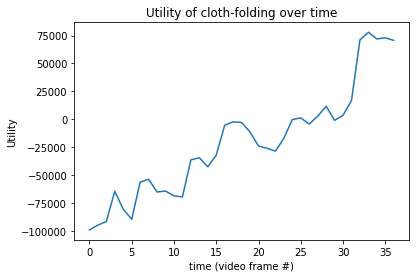

In [10]:
plt.figure()
plt.title('Utility of cloth-folding over time')
plt.xlabel('time (video frame #)')
plt.ylabel('Utility')
plt.plot(scores[-1])